In [ ]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import *
from keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3, preprocess_input
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def data_prep(parasitized,uninfected):

    parasitized= ["/content/drive/MyDrive/Malaria-Detection-Data/cell_images/Parasitized" + '/' +  parasitize for parasitize in parasitized]
    uninfected= ["/content/drive/MyDrive/Malaria-Detection-Data/cell_images/Uninfected" + '/' +  uninfect for uninfect in uninfected]

    labels = len(parasitized)*['parasitized'] + len(uninfected)*['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir('/content/drive/MyDrive/Malaria-Detection-Data/cell_images/Parasitized/'), os.listdir('/content/drive/MyDrive/Malaria-Detection-Data/cell_images/Uninfected/'))

In [ ]:
train, test = train_test_split(df, test_size = .20)

img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest', validation_split=0.2)
                               
                               
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
def plot_loss_and_accuracy(mo_fit):
    accuracy = mo_fit.history['accuracy']
    loss = mo_fit.history['loss']
    validation_loss = mo_fit.history['val_loss']
    validation_accuracy = mo_fit.history['val_accuracy']



    plt.figure(figsize=(15, 7))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
    plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Accuracy : Training Vs Validation ')



    plt.subplot(2, 2, 2)
    plt.plot(range(len(accuracy)), loss, label='Training Loss')
    plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
    plt.title('Loss : Training Vs Validation ')
    plt.legend(loc='upper right')
    plt.show()

Found 17639 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 314s 3s/step - loss: 1.6208 - accuracy: 0.5230 - val_loss: 0.7033 - val_accuracy: 0.5250
Epoch 2/4
100/100 [==============================] - 144s 1s/step - loss: 0.6963 - accuracy: 0.5330 - val_loss: 0.6754 - val_accuracy: 0.5710
Epoch 3/4
100/100 [==============================] - 148s 1s/step - loss: 0.6851 - accuracy: 0.5560 - val_loss: 0.6625 - val_accuracy: 0.6090
Epoch 4/4
100/100 [==============================] - 139s 1s/step - loss: 0.6958 - accuracy: 0.5450 - val_loss: 0.6735 - val_accuracy: 0.5730


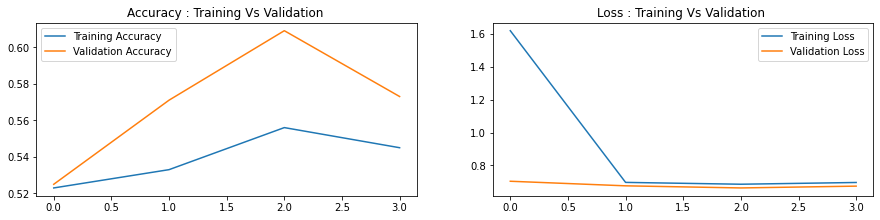

In [ ]:
def cnn_model(df, train, test, my_callbacks):
    
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(134,134), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(134,134), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1, activation='sigmoid')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model_history = model.fit_generator(generator = x_train, 
                   steps_per_epoch = 100,
                   epochs = 4 ,
                   validation_data = x_test,
                   validation_steps = 100, callbacks=my_callbacks)
    
    return model_history

    
plot_loss_and_accuracy(cnn_model(df, train, test, my_callbacks))

Found 17639 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 172s 2s/step - loss: 0.9774 - accuracy: 0.5120 - val_loss: 0.6925 - val_accuracy: 0.4900
Epoch 2/5
100/100 [==============================] - 159s 2s/step - loss: 0.5982 - accuracy: 0.6630 - val_loss: 0.3290 - val_accuracy: 0.8830
Epoch 3/5
100/100 [==============================] - 142s 1s/step - loss: 0.3665 - accuracy: 0.9090 - val_loss: 0.1597 - val_accuracy: 0.9540
Epoch 4/5
100/100 [==============================] - 134s 1s/step - loss: 0.3288 - accuracy: 0.9100 - val_loss: 0.2547 - val_accuracy: 0.9150
Epoch 5/5
100/100 [==============================] - 132s 1s/step - loss: 0.2958 - accuracy: 0.9280 - val_loss: 0.1821 - val_accuracy: 0.9460


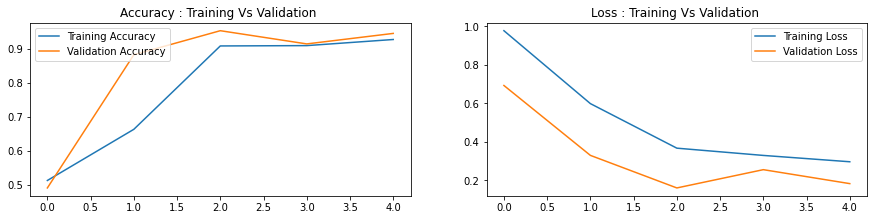

In [ ]:
def vgg19_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)
    model=Sequential()
    model.add(vgg19_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    model_history = model.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100, 
    epochs = 5 , callbacks=my_callbacks)
    
    return model_history
    
plot_loss_and_accuracy(vgg19_model(df, train, test, my_callbacks))